### A. PROBLEM STATEMENT:
The objective is to estimate the likelihood of survival for patients admitted to intensive care, based on data collected during their first 24 hours of hospitalization.

In [189]:
import numpy as np
np.random.seed(42)


### B. UNDERSTADNING OUR DATA:
The dataset originates from the WiDS Datathon 2020 Kaggle competition. At this stage, our focus is on exploring, familiarizing ourselves with, and gaining a deeper understanding of the data’s structure, variables, and quality before moving into preprocessing and modeling.

In [191]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
# loading the data
data_train = pd.read_csv("training_v2.csv")
data_test = pd.read_csv("unlabeled.csv")
data_info = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
data_sol = pd.read_csv("solution_template.csv")
data_sample = pd.read_csv("samplesubmission.csv")

In [193]:
# brief description of training data
data_train.hospital_death.unique()


array([0, 1])

In [194]:
# our data shape
print("data train shape:", data_train.shape)
print("data test shape:", data_test.shape)
print("data columns shape:", data_info.shape)


data train shape: (91713, 186)
data test shape: (39308, 186)
data columns shape: (188, 6)


### C. ANALYSIS:
The dataset is extensive, containing a large number of features and a substantial volume of sample records.



In [196]:
data_info['Data Type'].value_counts()

Data Type
numeric    153
binary      16
string      12
integer      7
Name: count, dtype: int64

### THE PLAN:
- Each category shows which variables are included.  
- The variables have different data types, so they must be handled correctly and with caution.







In [198]:
# deep understanding of the features datatype - extracting their name
objects = list(data_train.select_dtypes(include = "object").columns)
n_objects = len(objects)
print("list of all objects features in the data:\n",objects,"\n", n_objects)
print()
numbers = list(data_train.select_dtypes(include= "number").columns)
n_numbers = len(numbers)
print(" list of all integers features in the data:\n",numbers,"\n",n_numbers)
print()

# checking overall features:
data_train.shape[1] == n_numbers + n_objects

# our data is mostly numbers and a few objects

list of all objects features in the data:
 ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'] 
 8

 list of all integers features in the data:
 ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', '

True

plotting for exibit features type distribtion

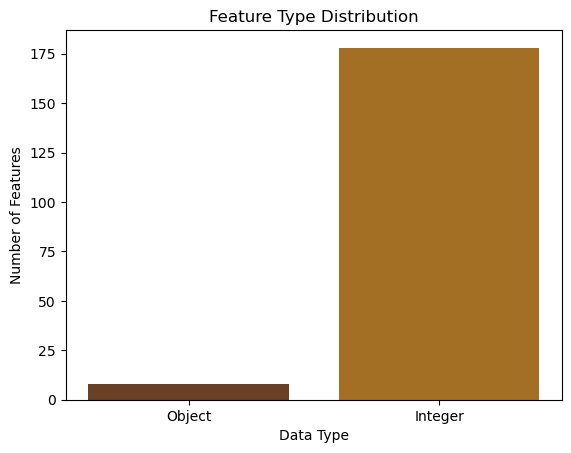

In [200]:
# data to plot
data_types = ['Object', 'Integer']
counts = [n_objects, n_numbers]

# Bar Plot
plt.bar(data_types, counts, color=['#693F26','#A26f25'])
plt.xlabel('Data Type')
plt.ylabel('Number of Features')
plt.title('Feature Type Distribution')

plt.show()


### BAR GRAPH ANALYSIS:
Most of the dataset is composed of numeric variables, including integers, floats, categorical values, and binary features. This requires careful treatment of categorical data and a consideration of whether certain variables should be excluded to improve the quality of the analysis.

In [202]:
# getting information about the features data type
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


### Plotting for exibit target data distribution


target =  [0 1]
hospital_death
0    83798
1     7915
Name: count, dtype: int64


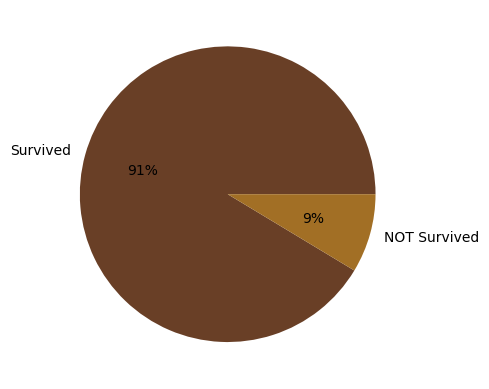

In [204]:
# identify target
print("target = ", data_train.hospital_death.unique())
# our target output has binary

# identify target values counts
output = data_train.hospital_death.value_counts()
print(output)

# visualizing target using pie chart
label = ['Survived','NOT Survived']
# custom colors
palette_color = ['#693F26', '#A26F25']

plt.pie(output, labels=label, colors=palette_color, autopct='%.0f%%')
plt.show()


### PIE CHART ANALYSIS:
The number of samples with an output of 0 is much higher than those with an output of 1. This imbalance between the two classes indicates that the dataset is skewed, and we plan to address it after completing the data cleaning process.


### D. DATA CLEANING:
1. **Handle Missing Values** – Identify and treat missing entries to ensure data completeness.  
2. **Encode Categorical Variables** – Convert categorical features into numeric form for modeling.  
3. **Feature Engineering and Selection** – Create new features and select the most relevant ones.  
4. **Address Imbalanced Data** – Apply techniques to balance class distributions for reliable results.  

### E. DATA PRE-PROCESSING:

In [208]:
# making a copy of our data to preserve the original datasets
dtrain = data_train.copy(deep=True)
dtest = data_test.copy(deep=True)
dinfo = data_info.copy(deep=False)


In [209]:
# save target coulmn

ytrain = dtrain['hospital_death']
dtrain = dtrain.drop('hospital_death', axis=1)

ytest = dtest['hospital_death']
dtest = dtest.drop('hospital_death', axis=1)

In [210]:
# Checking for duplicating rows
print(dtrain.duplicated().sum())
print(dtest.duplicated().sum())

0
0


### Training Data – Missing Values DataFrame
We are creating a DataFrame to collect and organize all information about missing values in our dataset. This will allow us to systematically identify which variables have missing entries, quantify the extent of missingness, and decide on appropriate strategies for handling them.

In [212]:
# Looking for missing values in the data train
pd.set_option('display.max_rows', None)

# Show only columns with missing values
MissingDTrain = dtrain.isnull().sum()
MissingDTrain = MissingDTrain[MissingDTrain > 0]
data_types_train = dtrain.dtypes[MissingDTrain.index]

missing_info_train = pd.DataFrame({
    'Variable Name': MissingDTrain.index,
    'HowManyMissingValues': MissingDTrain.values,
    'DataTypeName': data_types_train.values,
    'PrecentageOfMissingValues':(MissingDTrain.values/dtrain.shape[0])*100
                                  })

# Create a mapping from 'Variable Name' to the desired column in data_info
mapping = data_info.set_index('Variable Name')['Data Type']

# Add the new column to missing_info_train
missing_info_train['Data Type'] = missing_info_train['Variable Name'].map(mapping)

# Sort the DataFrame by the 'HowManyMissingValues' column in ascending order
missing_info_train = missing_info_train.sort_values(by='HowManyMissingValues', ascending=True)

# Print the total number of missing values
print("HowManyMissingValues = ", missing_info_train['HowManyMissingValues'].sum())

# Display the updated DataFrame
missing_info_train



HowManyMissingValues =  5743492


,Variable Name,HowManyMissingValues,DataTypeName,PrecentageOfMissingValues,Data Type
3,gender,25,object,0.027259,string
6,icu_admit_source,112,object,0.122120,string
41,d1_heartrate_max,145,float64,0.158102,numeric
42,d1_heartrate_min,145,float64,0.158102,numeric
56,d1_sysbp_min,159,float64,0.173367,numeric
55,d1_sysbp_max,159,float64,0.173367,numeric
38,d1_diasbp_min,165,float64,0.179909,numeric
37,d1_diasbp_max,165,float64,0.179909,numeric
45,d1_mbp_max,220,float64,0.239879,numeric
46,d1_mbp_min,220,float64,0.239879,numeric


In [213]:
# understanding what type of features having missing values
miss = missing_info_train.groupby('DataTypeName')['Variable Name'].count().reset_index()
print("HowManyMissingFeatures = ",miss['Variable Name'].sum())
miss

HowManyMissingFeatures =  175


,DataTypeName,Variable Name
0,float64,169
1,object,6


**Observation:** Most of our missing values are in numeric data types.

### E. NEXT STEPS:
Most of the missing values in our training dataset occur within numeric data types. This highlights the need to carefully decide on appropriate strategies for handling missing numeric values, such as imputation or removal, during the preprocessing stage.  

In [216]:
# How many float numbers features are missing in the data train
NoMissTrain = missing_info_train[missing_info_train['DataTypeName'] == 'float64']

# All missing values Variable Names of type float:
list(NoMissTrain['Variable Name'])


['d1_heartrate_max',
 'd1_heartrate_min',
 'd1_sysbp_min',
 'd1_sysbp_max',
 'd1_diasbp_min',
 'd1_diasbp_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_spo2_min',
 'd1_spo2_max',
 'd1_resprate_max',
 'd1_resprate_min',
 'lymphoma',
 'ventilated_apache',
 'intubated_apache',
 'cirrhosis',
 'aids',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'arf_apache',
 'leukemia',
 'solid_tumor_with_metastasis',
 'heart_rate_apache',
 'map_apache',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_noninvasive_max',
 'gcs_unable_apache',
 'd1_diasbp_noninvasive_min',
 'd1_diasbp_noninvasive_max',
 'apache_3j_diagnosis',
 'resprate_apache',
 'height',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'apache_2_diagnosis',
 'gcs_verbal_apache',
 'gcs_motor_apache',
 'gcs_eyes_apache',
 'd1_temp_min',
 'd1_temp_max',
 'weight',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'bmi',
 'h1_sysbp_min',
 'h1_sysbp_max',
 'h1_diasbp_min',
 'h1_diasbp_max',
 'temp_apache',
 'h1_spo2_max',
 'h1_spo2_min',


### NEXT STEP:
Most of the missing values in our training dataset are found in object data types. This indicates that categorical or string-based variables require special attention, such as encoding strategies or imputation, during the preprocessing stage.  


In [218]:
# How many object numbers features are missing in the data train
ObjMissTrain = missing_info_train[missing_info_train['DataTypeName'] == 'object']

# All missing values Variable Names of type object:
list(ObjMissTrain['Variable Name'])

['gender',
 'icu_admit_source',
 'ethnicity',
 'apache_2_bodysystem',
 'apache_3j_bodysystem',
 'hospital_admit_source']

In [219]:
# Identify the features with incorrect data types in missing_info_train
condition = (missing_info_train['DataTypeName'] == 'float64') & (missing_info_train['Data Type'] == 'string')
missing_info_train.loc[condition, 'Data Type'] = 'numeric'
wrong_features_datatype = missing_info_train[condition]
wrong_features = wrong_features_datatype['Variable Name']

# Update the data types in dtrain and dtest
dtrain[wrong_features] = dtrain[wrong_features].astype('float64')
dtest[wrong_features] = dtest[wrong_features].astype('float64')

# need also to update in the info file
# Update the info file to reflect the correct data type
dinfo.loc[dinfo['Variable Name'].isin(wrong_features), 'Data Type'] = 'numeric'

### NEXT STEP:
Numeric and integer variables with missing values should be imputed using either the mean or median, depending on the distribution (for example, median for skewed data and mean for normally distributed data). Binary variables should be imputed using the mode, since they are categorical in nature. For string variables, it may be necessary to drop features with missing values, particularly if they are not critical to the analysis or if the proportion of missing data is high.  



### TESTING – MISSING VALUES DATAFRAME  
We are creating a DataFrame to collect and organize all information about missing values in the testing dataset. This structure will help us identify which variables have missing entries, measure the extent of missingness, and decide on the most appropriate strategies for handling them during preprocessing.  


In [222]:
# Looking for missing values in the data test
pd.set_option('display.max_rows', None)

# Show only columns with missing values
MissingDTest = dtest.isnull().sum()
MissingDTest = MissingDTest[MissingDTest > 0]
MissingDTest

data_types_test = dtest.dtypes[MissingDTest.index]

missing_info_test = pd.DataFrame({
    'Variable Name': MissingDTest.index,
    'HowManyMissingValues': MissingDTest.values,
    'DataTypeName': data_types_test.values,
    'PrecentageOfMissingValues':(MissingDTest.values/dtest.shape[0])*100
                            })

# Create a mapping from 'Variable Name' to the desired column in data_info
mapping = data_info.set_index('Variable Name')['Data Type']

# Add the new column to missing_info_train
missing_info_test['Data Type'] = missing_info_test['Variable Name'].map(mapping)

# Sort the DataFrame by the 'HowManyMissingValues' column in ascending order
missing_info_test = missing_info_test.sort_values(by='HowManyMissingValues', ascending=True)

# Print the total number of missing values
print("HowManyMissingValues = ", missing_info_test['HowManyMissingValues'].sum())
missing_info_test

HowManyMissingValues =  2387194


,Variable Name,HowManyMissingValues,DataTypeName,PrecentageOfMissingValues,Data Type
3,gender,15,object,0.038160,string
46,d1_mbp_min,100,float64,0.254401,numeric
45,d1_mbp_max,100,float64,0.254401,numeric
38,d1_diasbp_min,104,float64,0.264577,numeric
37,d1_diasbp_max,104,float64,0.264577,numeric
55,d1_sysbp_max,104,float64,0.264577,numeric
56,d1_sysbp_min,104,float64,0.264577,numeric
41,d1_heartrate_max,111,float64,0.282385,numeric
42,d1_heartrate_min,111,float64,0.282385,numeric
6,icu_admit_source,115,object,0.292561,string


In [223]:
missing_info_test.groupby('DataTypeName')['Variable Name'].count().reset_index()

,DataTypeName,Variable Name
0,float64,169
1,object,6


### **NEXT STEP:**  
In the testing dataset, most of the missing values are found in numeric variables. This means that imputation strategies such as replacing with the mean or median, depending on the distribution of each variable, will be necessary to ensure data consistency and reliability during preprocessing.  


In [225]:
NoMissTest = missing_info_test[missing_info_test['DataTypeName'] == 'float64']

# All missing values Variable Names of type float:
list(NoMissTest['Variable Name'])

['d1_mbp_min',
 'd1_mbp_max',
 'd1_diasbp_min',
 'd1_diasbp_max',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'intubated_apache',
 'leukemia',
 'aids',
 'lymphoma',
 'ventilated_apache',
 'solid_tumor_with_metastasis',
 'immunosuppression',
 'arf_apache',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_resprate_min',
 'd1_resprate_max',
 'map_apache',
 'heart_rate_apache',
 'resprate_apache',
 'gcs_unable_apache',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_noninvasive_max',
 'apache_3j_diagnosis',
 'height',
 'd1_mbp_noninvasive_min',
 'd1_mbp_noninvasive_max',
 'weight',
 'apache_2_diagnosis',
 'bmi',
 'gcs_verbal_apache',
 'gcs_motor_apache',
 'gcs_eyes_apache',
 'h1_heartrate_min',
 'h1_heartrate_max',
 'age',
 'h1_mbp_min',
 'h1_mbp_max',
 'h1_sysbp_min',
 'h1_sysbp_max',
 'h1_diasbp_min',
 'h1_diasbp_max',
 'h1_spo2_min',
 'h1_spo2_max',
 'h1_respr

### **NEXT STEP:**  
In the testing dataset, the majority of missing values occur in object data types. This suggests that categorical or string-based variables need special handling, such as imputation with the most frequent category, introducing a placeholder for missing entries, or dropping features entirely if the proportion of missing values is too high and the variable is not critical to the analysis.  


In [227]:
# How many object numbers features are missing in the data train
ObjMissTest = missing_info_test[missing_info_test['DataTypeName'] == 'object']

# All missing values Variable Names of type object:
list(ObjMissTest['Variable Name'])

['gender',
 'icu_admit_source',
 'ethnicity',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'hospital_admit_source']

### **NB:** Change features with DataTypeName = 'float' but Data Type = 'string' to prevent missing missing values tracking

In [229]:
# Identify the features with incorrect data types in missing_info_test
Condition = (missing_info_test['DataTypeName'] == 'float64') & (missing_info_test['Data Type'] == 'string')
missing_info_test.loc[Condition, 'Data Type'] = 'numeric'
Wrong_features_datatype = missing_info_test[Condition]
Wrong_features = Wrong_features_datatype['Variable Name']

# Update the data types in  dtest
dtest[Wrong_features] = dtest[Wrong_features].astype('float64')


Handling Missing data and Encode Categorical Variables:

### EVALUATING OF HANDLING MISSING VALUES
Consider dropping features with missing string values if they are not critical or if the proportion of missing data is high.  

**PLAN:**  
Drop features that have a high percentage of missing values to maintain dataset quality and reduce noise in the analysis.  


### TRAIN DATA MISSING VALUES

In [233]:
threshold_train = 80

# Filter the features where the percentage of missing values is greater than the threshold
features_to_drop_train = missing_info_train[missing_info_train['PrecentageOfMissingValues'] > threshold_train]
features_to_drop_train_list = list(features_to_drop_train['Variable Name'])

# Drop the features from dtrain
dtrain = dtrain.drop(features_to_drop_train_list, axis=1)

# Drop the corresponding rows from missing_info_train
missing_info_train = missing_info_train[~missing_info_train['Variable Name'].isin(features_to_drop_train_list)]


### TEST DATA MISSING VALUES

In [235]:
threshold_test = 80

# Filter the features where the percentage of missing values is greater than the threshold
features_to_drop_test = missing_info_test[missing_info_test['PrecentageOfMissingValues'] > threshold_test]
features_to_drop_test_list = list(features_to_drop_test['Variable Name'])

# Drop the features from dtrain
dtest = dtest.drop(features_to_drop_test_list, axis=1)

# Drop the corresponding rows from missing_info_train
missing_info_test = missing_info_test[~missing_info_test['Variable Name'].isin(features_to_drop_test_list)]


###  REPLACE MISSING NUMERIC AND INTGER VALUES**  
Use the mean or median for imputation, based on the analysis of each feature’s distribution (e.g., normal vs. skewed).  

**NEXT PLAN:**  
1. Plot each numeric feature to visually assess its distribution.  
2. Calculate the skewness of each feature to computationally determine whether the distribution is normal or skewed.  
3. Apply mean imputation for normally distributed features and median imputation for skewed features.  
4. Revisit features that were not clearly identified by skewness and apply alternative strategies (e.g., domain knowledge or advanced imputation methods).  

  

### THE REMAINING FEATURES OF TRAIN DATA BASED ON THEIR TYPE Train

In [238]:
# Only Numeric
NumFeaturesTrain = missing_info_train[(missing_info_train['Data Type'] == 'numeric')|(missing_info_train['Data Type'] == 'integer')]
NumFeaturesTrain = list(NumFeaturesTrain['Variable Name'])
print(f'there are {len(NumFeaturesTrain)} features of Numeric')

# Only Binary
BinFeaturesTrain = missing_info_train[(missing_info_train['Data Type'] == 'binary')]
BinFeaturesTrain = list(BinFeaturesTrain['Variable Name'])
print(f'there are {len(BinFeaturesTrain)} features of Binary')

# Only object
CatFeaturesTrain = missing_info_train[missing_info_train['DataTypeName'] == 'object']
CatFeaturesTrain = list(CatFeaturesTrain['Variable Name'])
print(f'there are {len(CatFeaturesTrain)} features of Object')

there are 123 features of Numeric
there are 12 features of Binary
there are 6 features of Object


### THE REMAINING FEATURES OF TRAIN TEST BASED ON THEIR TYPE

In [240]:
# Only Numeric
NumFeaturesTest = missing_info_test[(missing_info_test ['Data Type'] == 'numeric')|(missing_info_test['Data Type'] == 'integer')]
NumFeaturesTest = list(NumFeaturesTest['Variable Name'])
print(f'there are {len(NumFeaturesTest)} features of Numeric')
# Only Binary
BinFeaturesTest = missing_info_test[(missing_info_test['Data Type'] == 'binary')]
BinFeaturesTest = list(BinFeaturesTest['Variable Name'])
print(f'there are {len(BinFeaturesTest)} features of Binary')
# Only object
CatFeaturesTest = missing_info_test[missing_info_test['DataTypeName'] == 'object']
CatFeaturesTest = list(CatFeaturesTest['Variable Name'])
print(f'there are {len(CatFeaturesTest)} features of Object')

there are 143 features of Numeric
there are 12 features of Binary
there are 6 features of Object


# **FEATURES ENGINEERING**

After data cleaning,there seems to be more columns in the test data than in the train data
Plan: is to remove any extra column in the test that is not in train bold text

In [243]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 151 entries, encounter_id to apache_2_bodysystem
dtypes: float64(136), int64(7), object(8)
memory usage: 105.7+ MB


In [244]:
dtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 171 entries, encounter_id to apache_2_bodysystem
dtypes: float64(156), int64(7), object(8)
memory usage: 51.3+ MB


In [245]:
dtrain.isnull().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
age                               4228
bmi                               3429
elective_surgery                     0
ethnicity                         1395
gender                              25
height                            1334
hospital_admit_source            21409
icu_admit_source                   112
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache                18853
fio2_apache              

In [246]:
dtest.isnull().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
age                               1654
bmi                               1086
elective_surgery                     0
ethnicity                          171
gender                              15
height                             750
hospital_admit_source            11948
icu_admit_source                   115
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                             764
albumin_apache                   24650
apache_2_diagnosis                 896
apache_3j_diagnosis                637
apache_post_operative                0
arf_apache                         179
bilirubin_apache                 25292
bun_apache                        7016
creatinine_apache                 6896
fio2_apache              

There seems to be lot's of null values,we have to clean data further

In [248]:
#dtest = dtest.drop(features_to_drop_train_list, axis=1)

In [249]:
dtest = dtest.drop(features_to_drop_train_list, axis=1, errors='ignore')

In [250]:
dtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 151 entries, encounter_id to apache_2_bodysystem
dtypes: float64(136), int64(7), object(8)
memory usage: 45.3+ MB


In [251]:
dtrain.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [252]:
dtest.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,56.0,21.102439,0,Caucasian,M,180.3,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,19.500595,1,Caucasian,F,145.0,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,66.0,32.518596,1,African American,M,170.2,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,64.0,20.798520,0,Caucasian,M,182.8,Operating Room,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,56.0,NaN,0,Caucasian,M,NaN,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


Applying mean imputation for normally distributed features and median imputation for skewed features.

For train

In [254]:
# Identify Numeric Columns (excluding ID colomns)
# We don't want to impute string identifiers
cols_to_exclude = ['dataset_source', 'group', 'encounter_id', 'patient_id']
numeric_cols = dtrain.select_dtypes(include=[np.number]).columns
numeric_cols = [c for c in numeric_cols if c not in cols_to_exclude]

# Calculate Skewness for all numeric features
skewness = dtrain[numeric_cols].skew()

# Threshold: If skewness is between -0.5 and 0.5, we consider it "Normal"
# Otherwise, we consider it "Skewed"
skew_limit = 0.5

# Dictionaries to track what we did
imputed_with_mean = []
imputed_with_median = []

In [255]:
# The Imputation Loop
for col in numeric_cols:
    skew_val = skewness[col]

    if abs(skew_val) < skew_limit:
        # Normal Distribution -> Use Mean
        mean_val = dtrain[col].mean()
        dtrain[col] = dtrain[col].fillna(mean_val)
        imputed_with_mean.append(col)
    else:
        # Skewed Distribution -> Use Median
        median_val = dtrain[col].median()
        dtrain[col] = dtrain[col].fillna(median_val)
        imputed_with_median.append(col)

In [256]:
# Report the Results
print(f"Total Numeric Features Processed: {len(numeric_cols)}")
print(f"Features imputed with MEAN (Normal): {len(imputed_with_mean)}")
print(f"Features imputed with MEDIAN (Skewed): {len(imputed_with_median)}")

Total Numeric Features Processed: 141
Features imputed with MEAN (Normal): 43
Features imputed with MEDIAN (Skewed): 98


In [257]:
# Print samples to verify
print("\nSample Normal Features:", imputed_with_mean[:5])
print("Sample Skewed Features:", imputed_with_median[:5])


Sample Normal Features: ['hospital_id', 'height', 'icu_id', 'readmission_status', 'albumin_apache']
Sample Skewed Features: ['age', 'bmi', 'elective_surgery', 'pre_icu_los_days', 'weight']


For test

In [259]:
# Identify Numeric Columns (excluding ID colomns)
# We don't want to impute string identifiers
cols_to_exclude = ['dataset_source', 'group', 'encounter_id', 'patient_id']
numeric_cols = dtest.select_dtypes(include=[np.number]).columns
numeric_cols = [c for c in numeric_cols if c not in cols_to_exclude]

# Calculate Skewness for all numeric features
skewness = dtest[numeric_cols].skew()

# Threshold: If skewness is between -0.5 and 0.5, we consider it "Normal"
# Otherwise, we consider it "Skewed"
skew_limit = 0.5

# Dictionaries to track what we did
imputed_with_mean = []
imputed_with_median = []

In [260]:
# The Imputation Loop
for col in numeric_cols:
    skew_val = skewness[col]

    if abs(skew_val) < skew_limit:
        # Normal Distribution -> Use Mean
        mean_val = dtest[col].mean()
        dtest[col] = dtest[col].fillna(mean_val)
        imputed_with_mean.append(col)
    else:
        # Skewed Distribution -> Use Median
        median_val = dtest[col].median()
        dtest[col] = dtest[col].fillna(median_val)
        imputed_with_median.append(col)

Removing the id columns because they are not important for our model

In [262]:
# Define the ID columns to remove
id_cols = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']

# Drop them from both dataframes
print(f"Columns before drop Train: {dtrain.shape[1]}")

dtrain = dtrain.drop(id_cols, axis=1, errors='ignore')

print(f"Columns after drop Train: {dtrain.shape[1]}")

Columns before drop Train: 151
Columns after drop Train: 147


In [263]:
# Define the ID columns to remove
id_cols = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']

# Drop them from both dataframes
print(f"Columns before drop Train: {dtest.shape[1]}")

dtest = dtest.drop(id_cols, axis=1, errors='ignore')

print(f"Columns after drop Train: {dtest.shape[1]}")

Columns before drop Train: 151
Columns after drop Train: 147


Cleaning and encoding categorical columns now

In [265]:
# 1. Identify Categorical Columns
# We verify which columns are actually text/object types
cat_cols = dtrain.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical Columns found: {len(cat_cols)}")
print(cat_cols)

Categorical Columns found: 8
['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [266]:
# 2. Impute Missing Values with Mode
# We calculate mode on TRAIN and use it to fill both TRAIN and TEST
for col in cat_cols:
    if col in dtrain.columns:
        # Find the most frequent value (Mode)
        mode_val = dtrain[col].mode()[0]

        # Fill missing values
        dtrain[col] = dtrain[col].fillna(mode_val)

        # Check if column exists in test before filling
        if col in dtest.columns:
            dtest[col] = dtest[col].fillna(mode_val)

print("Categorical missing values filled with Mode.")

Categorical missing values filled with Mode.


In [267]:
# 3. One-Hot Encoding
# This converts 'gender' into 'gender_M' and 'gender_F'
dtrain_encoded = pd.get_dummies(dtrain, columns=cat_cols)
dtest_encoded = pd.get_dummies(dtest, columns=cat_cols)

In [268]:
dtrain_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 199 entries, age to apache_2_bodysystem_Undefined diagnoses
dtypes: bool(60), float64(136), int64(3)
memory usage: 102.5 MB


In [269]:
dtest_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 198 entries, age to apache_2_bodysystem_Undefined diagnoses
dtypes: bool(59), float64(136), int64(3)
memory usage: 43.9 MB


In [270]:
# 4.
# The encoding might create different columns for Train vs Test.
# We force Test to have exactly the same feature columns as Train.

# Align test to match train features (fill missing with 0, drop extras)
dtest_aligned = dtest_encoded.reindex(columns=dtrain_encoded.columns, fill_value=0)

# Rename dataframes for clarity
dtrain_final = dtrain_encoded
dtest_final = dtest_aligned

print(f"\nFinal Shapes after Encoding & Alignment:")
print(f"Train: {dtrain_final.shape}")
print(f"Test:  {dtest_final.shape}")


Final Shapes after Encoding & Alignment:
Train: (91713, 199)
Test:  (39308, 199)


**Now reducing the columns to only top 10 most correlated columns to our target to develop more practical model**

In [272]:
# 1. Define Target and Features
target_col = 'hospital_death'
X = dtrain_final
y = ytrain

# 2. Calculate Correlation with Target
# We use .abs() because a strong negative correlation (like GCS)
# is just as important as a strong positive one (like Age)
correlations = X.corrwith(y).abs().sort_values(ascending=False)

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [273]:
correlations

d1_lactate_max                                0.309711
d1_lactate_min                                0.309619
apache_4a_hospital_death_prob                 0.300259
apache_4a_icu_death_prob                      0.274050
gcs_motor_apache                              0.273661
gcs_eyes_apache                               0.250703
gcs_verbal_apache                             0.231056
ventilated_apache                             0.226405
d1_sysbp_min                                  0.209780
d1_spo2_min                                   0.209326
d1_sysbp_noninvasive_min                      0.208513
d1_temp_min                                   0.202283
d1_arterial_ph_min                            0.198468
d1_mbp_min                                    0.194916
d1_mbp_noninvasive_min                        0.193877
d1_diasbp_min                                 0.179225
d1_diasbp_noninvasive_min                     0.178564
d1_bun_max                                    0.176135
intubated_

Summing all the GCS values to get the GCS score which is more relevant in clinical setting

In [275]:
# 1. Define the component columns
gcs_cols = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# 2. Sum them up
# We use min_count=3 to ensure we only get a total if ALL 3 components exist.
# (A GCS of 10 is meaningless if we don't know the verbal score)
dtrain_final['gcs_total'] = dtrain_final[gcs_cols].sum(axis=1, min_count=3)

In [276]:
dtrain_final['gcs_total'].isnull().sum()

0

In [277]:
# Applying same for test

# 2. Sum them up
# We use min_count=3 to ensure we only get a total if ALL 3 components exist.
# (A GCS of 10 is meaningless if we don't know the verbal score)
dtest_final['gcs_total'] = dtest_final[gcs_cols].sum(axis=1, min_count=3)

In [278]:
dtest_final['gcs_total'].isnull().sum()

0

Re running the correlations with the new GCS score

In [280]:
# 1. Define Target and Features
target_col = 'hospital_death'
X = dtrain_final
y = ytrain

# 2. Calculate Correlation with Target
# We use .abs() because a strong negative correlation (like GCS)
# is just as important as a strong positive one (like Age)
correlations = X.corrwith(y).abs().sort_values(ascending=False)
correlations

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


d1_lactate_max                                0.309711
d1_lactate_min                                0.309619
apache_4a_hospital_death_prob                 0.300259
apache_4a_icu_death_prob                      0.274050
gcs_motor_apache                              0.273661
gcs_total                                     0.273556
gcs_eyes_apache                               0.250703
gcs_verbal_apache                             0.231056
ventilated_apache                             0.226405
d1_sysbp_min                                  0.209780
d1_spo2_min                                   0.209326
d1_sysbp_noninvasive_min                      0.208513
d1_temp_min                                   0.202283
d1_arterial_ph_min                            0.198468
d1_mbp_min                                    0.194916
d1_mbp_noninvasive_min                        0.193877
d1_diasbp_min                                 0.179225
d1_diasbp_noninvasive_min                     0.178564
d1_bun_max

Correlation Heatmap

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 30 Correlated Features identified.


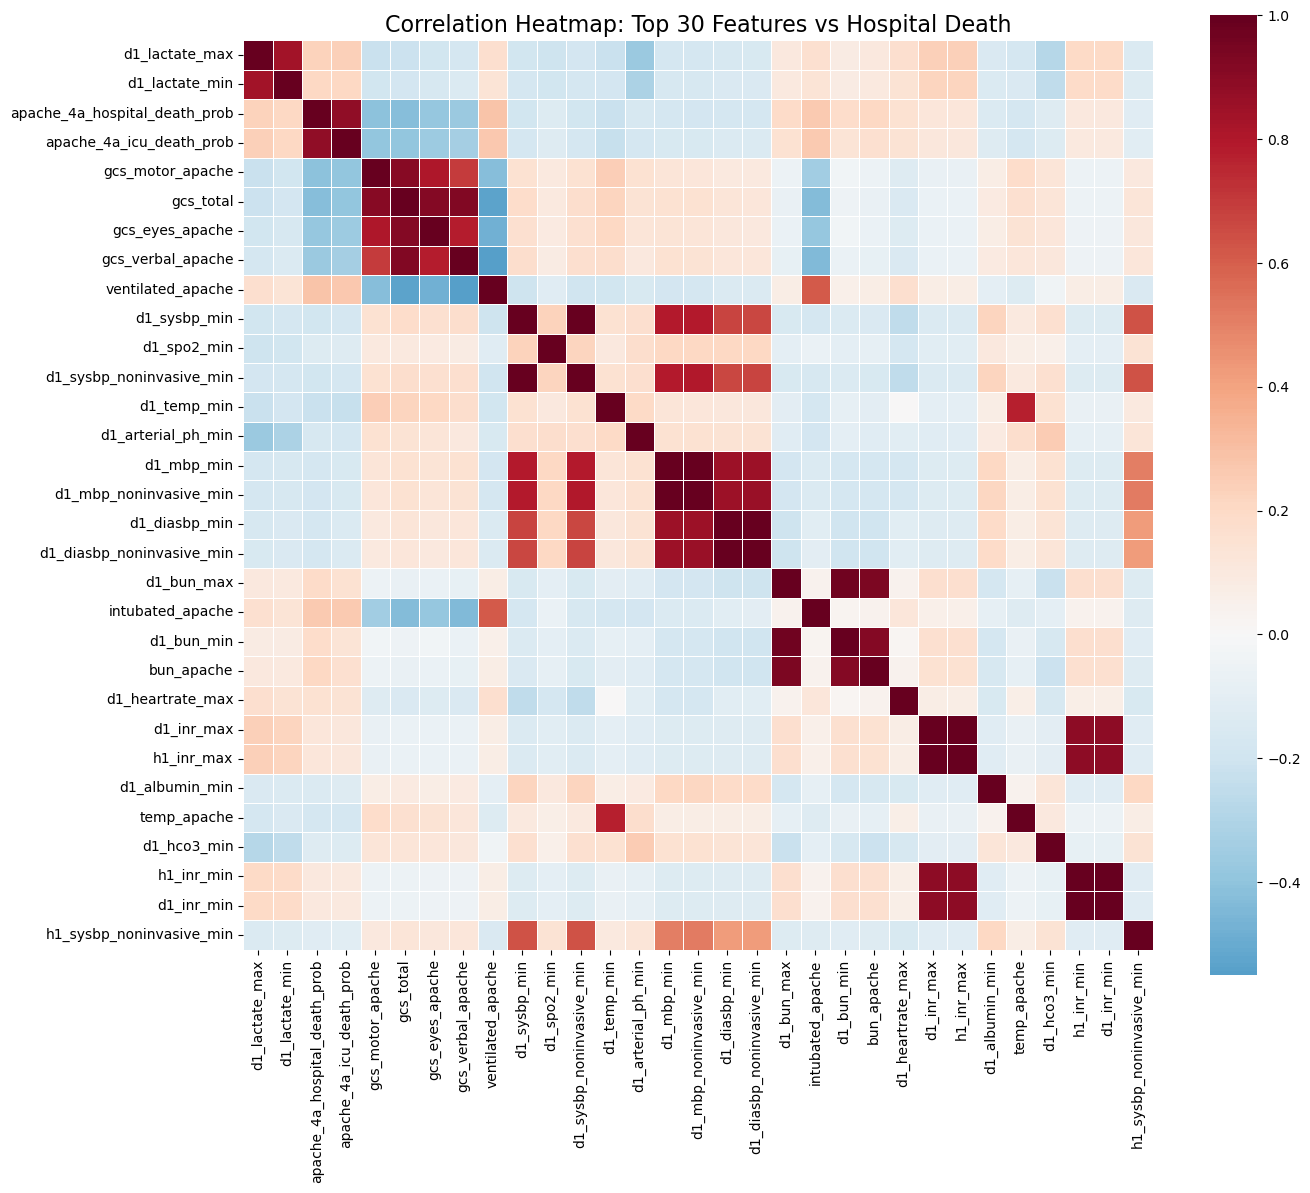

['d1_lactate_max', 'd1_lactate_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'gcs_motor_apache', 'gcs_total', 'gcs_eyes_apache', 'gcs_verbal_apache', 'ventilated_apache', 'd1_sysbp_min', 'd1_spo2_min', 'd1_sysbp_noninvasive_min', 'd1_temp_min', 'd1_arterial_ph_min', 'd1_mbp_min', 'd1_mbp_noninvasive_min', 'd1_diasbp_min', 'd1_diasbp_noninvasive_min', 'd1_bun_max', 'intubated_apache', 'd1_bun_min', 'bun_apache', 'd1_heartrate_max', 'd1_inr_max', 'h1_inr_max', 'd1_albumin_min', 'temp_apache', 'd1_hco3_min', 'h1_inr_min', 'd1_inr_min', 'h1_sysbp_noninvasive_min']


In [282]:
#  Prepare Data for Correlation
df_for_corr = dtrain_final.copy()

target_corrs = dtrain_final.corrwith(y).abs()

#  Get the Top 30 Features
top_30_features = target_corrs.sort_values(ascending=False).head(31).index.tolist()
# (We grab 31 because 'hospital_death' itself will be #1)

print("Top 30 Correlated Features identified.")

# Generate the Heatmap
plt.figure(figsize=(14, 12))

# We compute the full correlation matrix just for these 30
# This shows how they relate to the target AND each other (redundancy check)
corr_matrix = dtrain_final[top_30_features].corr()

sns.heatmap(corr_matrix,
            annot=False,    # Turn off numbers to keep it clean
            cmap='RdBu_r',  # Red=Positive, Blue=Negative
            center=0,
            square=True,
            linewidths=0.5)

plt.title('Correlation Heatmap: Top 30 Features vs Hospital Death', fontsize=16)
plt.tight_layout()
plt.show()

# Print the list to read
print(top_30_features)

*  Selecting 10 most relevant features out of
the top ones because some of them almost mean the same thing or have similar correlations,eg. sysBP and invsysBP are thesame thing.
*   Also some of them are derived features and wont make much sense in real clinical setting. eg.Hospital death probaility

In [284]:
# 1. Defining Features List
clinical_features = [
    'd1_lactate_max',       # major indicator for sepsis
    'gcs_total',            # Neurological indicator (Computed)
    'ventilated_apache',    # Could suggest hypoxia presence
    'd1_sysbp_min',         # CV determinant of shock
    'd1_spo2_min',          # Suggest the nedd for ventialtion
    'd1_temp_min',          # Also a determinant of sepsis
    'd1_arterial_ph_min',   # Determine metabolic derangement
    'd1_bun_max',           # Determine kidney functioon
    'd1_heartrate_max',     # Determines arrythmias,e.g fibrillations
    'd1_inr_max'            # Tells us about coagulopathies
]

#2. Determimning available features
# (In case some were dropped earlier)
available_features = [c for c in clinical_features if c in dtrain_final.columns]

print(f"Requested {len(clinical_features)} features.")
print(f"Found {len(available_features)} features in the dataset.")

if len(clinical_features) != len(available_features):
    print("MISSING:", set(clinical_features) - set(available_features))

# 3. Create the Final Training Data
# We include the target 'hospital_death' for training
dtrain_ready = dtrain_final[available_features].copy()
dtrain_ready['hospital_death'] = y

# 4. Create the Final Test Data
# We only need the features
dtest_ready = dtest_final[available_features].copy()

print("\nFinal Data Shape for Modeling:")
print(f"Train: {dtrain_ready.shape}")
print(f"Test:  {dtest_ready.shape}")

Requested 10 features.
Found 10 features in the dataset.

Final Data Shape for Modeling:
Train: (91713, 11)
Test:  (39308, 10)


In [285]:
# 3. Create the Final Training Data
# We include the target 'hospital_death' for training
dtrain_ready = dtrain_final[available_features].copy()
dtrain_ready['hospital_death'] = y

# 4. Create the Final Test Data
# We only need the features
dtest_ready = dtest_final[available_features].copy()

print("\nFinal Data Shape for Modeling:")
print(f"Train: {dtrain_ready.shape}")
print(f"Test:  {dtest_ready.shape}")

dtrain_ready.to_csv('training_ready_data.csv', index=False)
dtest_ready.to_csv('testing_ready_data.csv', index=False)


Final Data Shape for Modeling:
Train: (91713, 11)
Test:  (39308, 10)


LOADING THE DATA

In [287]:
df = pd.read_csv('training_ready_data.csv')
df.head()

,d1_lactate_max,gcs_total,ventilated_apache,d1_sysbp_min,d1_spo2_min,d1_temp_min,d1_arterial_ph_min,d1_bun_max,d1_heartrate_max,d1_inr_max,hospital_death
0,1.3,13.0,0.0,73.0,74.0,37.2,7.34,31.0,119.0,1.3,0
1,3.5,5.0,1.0,67.0,70.0,35.1,7.45,11.0,118.0,1.3,0
2,1.9,14.0,0.0,105.0,91.0,36.7,7.34,19.0,96.0,1.3,0
3,1.9,15.0,1.0,84.0,95.0,34.8,7.34,19.0,116.0,1.6,0
4,1.9,15.0,0.0,120.0,96.0,36.7,7.34,19.0,89.0,1.3,0


IMPORTING THE MODELS

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# PREPARING THE DATA

x = df.drop(columns=['hospital_death'])
y = df['hospital_death']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# MODEL SELECTION WITH CLASS WIEGHT TO PREVENT OVERFITIING AND GIVE MORE WEIGHT TO DEATH THAN SURVIVAL

model = DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10, class_weight='balanced', random_state=42)
model.fit(x_train, y_train)


# EVALUATING THE MODEL

def evaluate_model(model, x_test, y_test):
  prediction = model.predict(x_test)
  accuracy = accuracy_score(y_test, prediction)
  matrix = confusion_matrix(y_test, prediction)
  return accuracy, matrix, prediction # Return prediction as well

accuracy, matrix, prediction = evaluate_model(model, x_test, y_test) # Capture prediction

# PRINTING THE ACCURACY AND CONFUSION MATRIX SCORE

print(f'accuracy:{accuracy*100:.2f}%')
print(f'Confusion_Matrix:')
print(matrix)
print(classification_report(y_test, prediction))

accuracy:75.64%
Confusion_Matrix:
[[12707  4049]
 [  419  1168]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     16756
           1       0.22      0.74      0.34      1587

    accuracy                           0.76     18343
   macro avg       0.60      0.75      0.60     18343
weighted avg       0.90      0.76      0.81     18343



In [290]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# preparing the data

x = df.drop(columns=['hospital_death'])
y = df['hospital_death']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#model selection

model = KNeighborsClassifier()
model.fit(x_train, y_train)

# evaluating the model

def evaluate_model(model, x_test, y_test):
  prediction = model.predict(x_test)
  accuracy = accuracy_score(y_test, prediction)
  matrix = confusion_matrix(y_test, prediction)
  return accuracy, matrix
accuracy, matrix = evaluate_model(model, x_test, y_test)
threshold = 0.3
print(f'accuracy:{accuracy*100:.2f}%')
print(f'Confusion_Matrix:')
print(matrix)

print(classification_report(y_test, prediction))

accuracy:91.69%
Confusion_Matrix:
[[16555   220]
 [ 1305   263]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80     16775
           1       0.08      0.28      0.13      1568

    accuracy                           0.68     18343
   macro avg       0.50      0.50      0.47     18343
weighted avg       0.84      0.68      0.75     18343



In [291]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score


# Checking class distribution
print("Class Distribution:")
print(y.value_counts())
print(f"\nDeath Rate: {y.mean():.2%}")

# Spliting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# 1. SCALING THE DATA
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 2. ADDRESSING CLASS IMBALANCE
#  UsING class weights
model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

# 3. TRAINING THE MODEL
model.fit(x_train_scaled, y_train)

# 4. EVALUATING
y_pred = model.predict(x_test_scaled)
y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]

# Calculating all metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("IMPROVED LOGISTIC REGRESSION RESULTS")
print(f"Accuracy:   {accuracy:.2%}")
print(f"Recall (Sensitivity): {recall:.2%}")
print(f"Precision:  {precision:.2%}")
print(f"F1-Score:   {f1:.2%}")
print(f"AUC-ROC:    {auc_roc:.2f}")

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)
print("Classification Report:", classification_report(y_test, y_pred, target_names=['Survived', 'Died']))

# Get predicted probabilities for the positive class
probabilities = model.predict_proba(x_test_scaled)[:, 1]

# Try different thresholds
for threshold in [0.3, 0.2, 0.15, 0.1]:
    y_pred_adjusted = (probabilities >= threshold).astype(int)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    print(f"\nThreshold = {threshold}:")
    print(f"  Recall: {recall_adjusted:.2%}")
    print(f"  Precision: {precision_adjusted:.2%}")
    print(f"  Deaths Predicted: {y_pred_adjusted.sum()} out of {y_test.sum()} actual")


Class Distribution:
hospital_death
0    83798
1     7915
Name: count, dtype: int64

Death Rate: 8.63%
IMPROVED LOGISTIC REGRESSION RESULTS
Accuracy:   78.79%
Recall (Sensitivity): 72.71%
Precision:  24.97%
F1-Score:   37.18%
AUC-ROC:    0.85

Confusion Matrix:
[[13302  3458]
 [  432  1151]]
Classification Report:               precision    recall  f1-score   support

    Survived       0.97      0.79      0.87     16760
        Died       0.25      0.73      0.37      1583

    accuracy                           0.79     18343
   macro avg       0.61      0.76      0.62     18343
weighted avg       0.91      0.79      0.83     18343


Threshold = 0.3:
  Recall: 90.46%
  Precision: 16.60%
  Deaths Predicted: 8628 out of 1583 actual

Threshold = 0.2:
  Recall: 96.34%
  Precision: 12.47%
  Deaths Predicted: 12233 out of 1583 actual

Threshold = 0.15:
  Recall: 98.55%
  Precision: 10.30%
  Deaths Predicted: 15144 out of 1583 actual

Threshold = 0.1:
  Recall: 99.68%
  Precision: 8.96%
  De

Confusion Matrix Plot saved.

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     16760
           1       0.25      0.73      0.37      1583

    accuracy                           0.79     18343
   macro avg       0.61      0.76      0.62     18343
weighted avg       0.91      0.79      0.83     18343



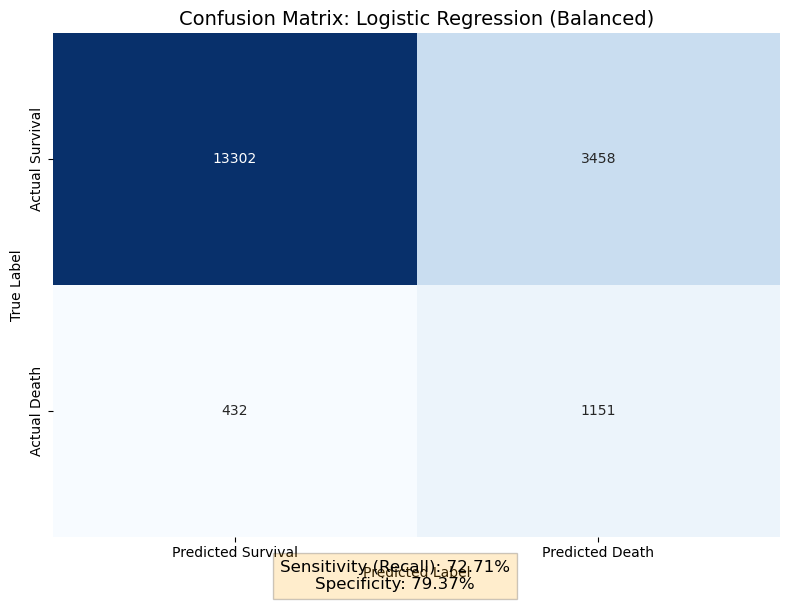

In [292]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Survival', 'Predicted Death'],
            yticklabels=['Actual Survival', 'Actual Death'])
plt.title('Confusion Matrix: Logistic Regression (Balanced)', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text for sensitivity/specificity for educational value
tp = cm[1, 1]
fn = cm[1, 0]
tn = cm[0, 0]
fp = cm[0, 1]
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

plt.figtext(0.5, 0.01, f'Sensitivity (Recall): {sensitivity:.2%}\nSpecificity: {specificity:.2%}', 
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
print("Confusion Matrix Plot saved.")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Upsampling the Decision Tree using SMOTE

First, we need to install the `imbalanced-learn` library.

In [294]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [295]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# Loading the ready training data
df = pd.read_csv('training_ready_data.csv')

x = df.drop(columns=['hospital_death'])
y = df['hospital_death']

# Spliting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original training set shape: X={x_train.shape}, y={y_train.shape}")
print(f"Original training target distribution:\n{y_train.value_counts()}")

# Applying SMOTE to the training data only
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print(f"\nResampled training set shape: X={x_train_resampled.shape}, y={y_train_resampled.shape}")
print(f"Resampled training target distribution:\n{y_train_resampled.value_counts()}")

# Model selection with the resampled data
# Removing class_weight='balanced' here as SMOTE has already balanced the classes
model_smote = DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10, random_state=42)
model_smote.fit(x_train_resampled, y_train_resampled)

# Evaluating the model
def evaluate_model(model, x_test, y_test):
  prediction = model.predict(x_test)
  accuracy = accuracy_score(y_test, prediction)
  matrix = confusion_matrix(y_test, prediction)
  return accuracy, matrix, prediction

accuracy_smote, matrix_smote, prediction_smote = evaluate_model(model_smote, x_test, y_test)

# Printing the accuracy and confusion matrix score
print(f'\nAccuracy with SMOTE: {accuracy_smote*100:.2f}%')
print(f'Confusion Matrix with SMOTE:')
print(matrix_smote)
print(classification_report(y_test, prediction_smote))

Original training set shape: X=(73370, 10), y=(73370,)
Original training target distribution:
hospital_death
0    67038
1     6332
Name: count, dtype: int64

Resampled training set shape: X=(134076, 10), y=(134076,)
Resampled training target distribution:
hospital_death
1    67038
0    67038
Name: count, dtype: int64

Accuracy with SMOTE: 87.01%
Confusion Matrix with SMOTE:
[[15198  1562]
 [  821   762]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16760
           1       0.33      0.48      0.39      1583

    accuracy                           0.87     18343
   macro avg       0.64      0.69      0.66     18343
weighted avg       0.90      0.87      0.88     18343



In [296]:
# trying the logreg model with 0.4 threshold 
for threshold in [0.4]:
    y_pred_adjusted = (probabilities >= threshold).astype(int)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    print(f"\nThreshold = {threshold}:")
    print(f"  Recall: {recall_adjusted:.2%}")
    print(f"  Precision: {precision_adjusted:.2%}")
    print(f"  Deaths Predicted: {y_pred_adjusted.sum()} out of {y_test.sum()} actual")


Threshold = 0.4:
  Recall: 81.30%
  Precision: 20.52%
  Deaths Predicted: 6272 out of 1583 actual


In [297]:
# saving the best model which is the balanced logistic regression with 0.5 threshold because it has balanced recall(73%) and precision on death.
# i.e it catches 3 out 4 dying patients while about 3 out of 4 predicted dying patients are false alarm
import joblib
# Save
joblib.dump(model, 'logreg_model.pkl')
print("\nModel saved as 'logreg_model.pkl'")


Model saved as 'logreg_model.pkl'


In [298]:
from sklearn.pipeline import Pipeline

# 1. Define the Pipeline (Scaler + Model)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42))
])

# 2. Train the Pipeline
pipeline.fit(x_train, y_train)

# 3. Save the PIPELINE
joblib.dump(pipeline, 'logreg_pipeline.pkl')
print("Saved pipeline as 'logreg_pipeline.pkl'")

Saved pipeline as 'logreg_pipeline.pkl'
